# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [65]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
imp

In [28]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [29]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [30]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.weights = tf.Variable(tf.random.normal([in_features, out_features]), name="weights")
        self.bias = tf.Variable(tf.zeros([out_features]), name="bias")

    def __call__(self, x):
        y = tf.matmul(x, self.weights) + self.bias
        return tf.nn.relu(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    
    # Первый слой, состоящий из 128 нейронов
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Второй слой, состоящий из 256 нейронов
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    
    # Выходной слой
    self.out_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    # Место для вашего кода
    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
    # принадлежности входного объекта к одному из 10 классов
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.out_layer(x)

    return tf.nn.softmax(x)

In [53]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(prediction, tf.float32))

In [56]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Создадим оптимизируемых список параметров
    train_var = nn.trainable_variables

    # Вычислим по ним значение градиента
    grad = g.gradient(loss, train_var)
    
    # Модифицируем параметры
    optimizer.apply_gradients(zip(grad, train_var))

In [57]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Обновляем веса нейронной сети
    train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)

        loss = cross_entropy(pred, batch_y)
        accur = accuracy(pred, batch_y)

        loss_history.append(loss)
        accuracy_history.append(accur)

        print(f"Step {step}, Loss: {loss}, Accuracy: {accur}")


Step 100, Loss: 3377.89208984375, Accuracy: 0.36328125
Step 200, Loss: 3543.67822265625, Accuracy: 0.33203125
Step 300, Loss: 3212.10595703125, Accuracy: 0.39453125
Step 400, Loss: 3046.31982421875, Accuracy: 0.42578125
Step 500, Loss: 2859.810546875, Accuracy: 0.4609375
Step 600, Loss: 3087.7666015625, Accuracy: 0.41796875
Step 700, Loss: 2818.364013671875, Accuracy: 0.46875
Step 800, Loss: 2984.14990234375, Accuracy: 0.4375
Step 900, Loss: 2963.4267578125, Accuracy: 0.44140625
Step 1000, Loss: 2942.70361328125, Accuracy: 0.4453125
Step 1100, Loss: 2839.08740234375, Accuracy: 0.46484375
Step 1200, Loss: 3004.87353515625, Accuracy: 0.43359375
Step 1300, Loss: 2507.51513671875, Accuracy: 0.52734375
Step 1400, Loss: 2341.72900390625, Accuracy: 0.55859375
Step 1500, Loss: 2984.150146484375, Accuracy: 0.4375
Step 1600, Loss: 2673.30126953125, Accuracy: 0.49609375
Step 1700, Loss: 2258.8359375, Accuracy: 0.57421875
Step 1800, Loss: 2258.8359375, Accuracy: 0.57421875
Step 1900, Loss: 2673.30

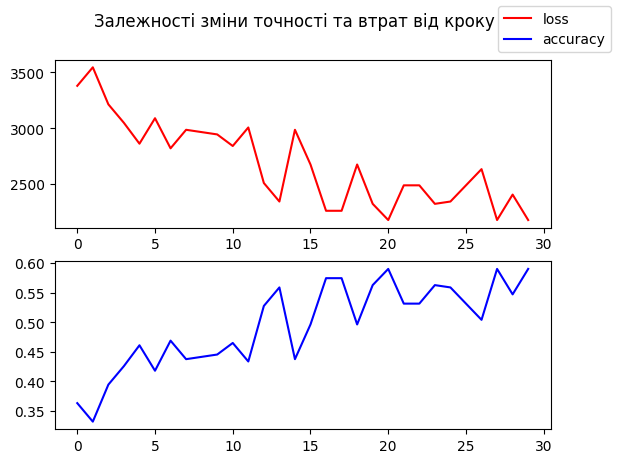

In [61]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

fig, axs = plt.subplots(2)
fig.suptitle('Залежності зміни точності та втрат від кроку')
axs[0].plot(loss_history, label='loss', c='r')
axs[1].plot(accuracy_history, label='accuracy', c='b')
fig.legend()
plt.show()

In [63]:
# Вычислите точность обученной нейросети

result = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {result}")

Accuracy: 0.5532000064849854


Label: 5, Predicted Label: 5


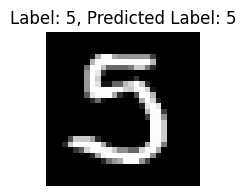

Label: 5, Predicted Label: 5


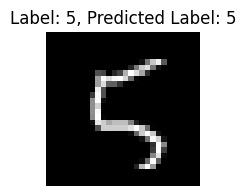

Label: 5, Predicted Label: 5


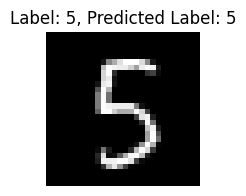

Label: 1, Predicted Label: 1


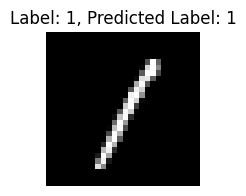

Label: 3, Predicted Label: 8


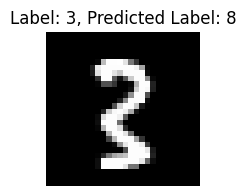

Label: 7, Predicted Label: 7


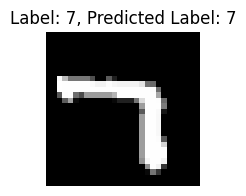

Label: 7, Predicted Label: 7


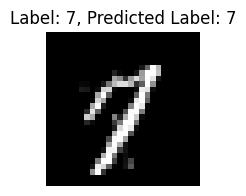

Label: 5, Predicted Label: 5


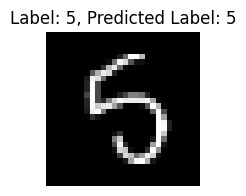

Label: 6, Predicted Label: 6


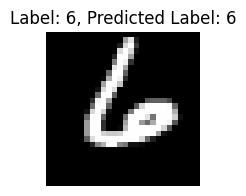

Label: 0, Predicted Label: 6


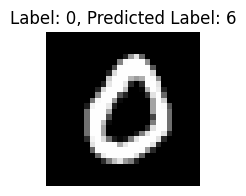

Correct result: 7 from 10


In [85]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?


number_of_images = 10

random_idx = random.sample(range(len(x_test)), number_of_images)
test_images = x_test[random_idx]
test_labels = y_test[random_idx]

predicts = neural_net(test_images)

predicts_labels = tf.argmax(predicts, axis=1)

count_true = 0
for i in range(len(test_images)):
    image = test_images[i].reshape((28, 28))
    label = test_labels[i]
    predicted_label = predicts_labels[i]
    print(f"Label: {label}, Predicted Label: {predicted_label}")
    if predicted_label == label:
        count_true += 1
    plt.figure(figsize=(2, 2))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {label}, Predicted Label: {predicted_label}")
    plt.show()
print(f'Correct result: {count_acc} from {number_of_images}')